### Created on 2023
### @author: S.W

#### References
- https://www.tensorflow.org/tutorials/generative/dcgan?hl=ko
- https://colab.research.google.com/drive/1v7OYMjLF1zkYUzcuCSUdpzUmIm_dCPPz#scrollTo=pZuOPwpc8dNa

-----

### 1. 학습에 필요한 라이브러리 불러오기

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt
import numpy as np
import os
import time

### 2. MNIST 데이터 불러오기 & 이미지 데이터 전처리

#### 이미지 데이터 전처리

In [2]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1).astype('float32')
test_images = (test_images - 127.5) / 127.5
# 마지막 layer의 활성화 함수로 sigmoid(0~1) 보다 tanh(-1~1)를 더 선호합니다.

print(train_images.shape)

(60000, 28, 28, 1)


#### 훈련 데이터셋에서 이미지 추출 후 랜덤 시각화

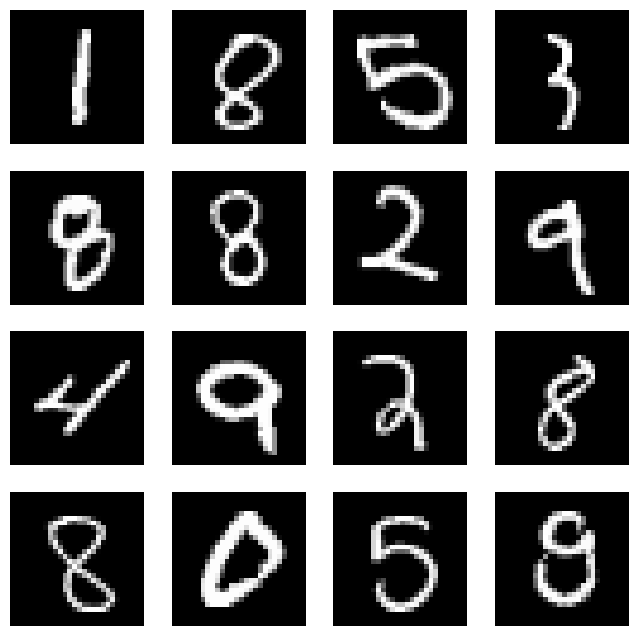

In [3]:
# 훈련 데이터셋에서 16개의 이미지 랜덤 선택
images = train_images[np.random.choice(train_images.shape[0], size=16, replace=False)]

# 이미지 시각화
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(8, 8))
for i, ax in enumerate(axes.flat):
    ax.imshow(images[i, :, :, 0], cmap='gray')
    ax.axis('off')
plt.show()

#### 데이터를 batch_size 단위로 분할

In [4]:
BUFFER_SIZE = 60000 # buffer_size는 몇 개의 데이터를 버퍼에 담을지를 결정합니다.
BATCH_SIZE = 128
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

### 3. 모델 정의
#### 생성자 모델
- G 모델은 Noise로 부터 원래의 데이터를 생성해내는 모델입니다.
- Input : 100차원의 noise
- Output : Mnist 이미지 크기인 28*28

In [5]:
def create_generator():
    
    input_noise = keras.Input(shape=(100,))
    x = layers.Dense(7*7*256, use_bias=False, input_shape=(100,))(input_noise)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    
    x = layers.Reshape((7, 7, 256))(x)
    
    x = layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    
    x = layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    
    output_img = layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')(x)

    model = tf.keras.Model(inputs=input_noise, outputs=output_img)
    return model

G = create_generator()
G.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
dense (Dense)                (None, 12544)             1254400   
_________________________________________________________________
batch_normalization (BatchNo (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 12544)             0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 7, 7, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 128)         512   

#### 판별자 모델
- D모델은 28*28 이미지가 실제 데이터인지 만들어진 데이터인지 판별합니다.
- Input : Mnist 이미지 (28*28)
- Output : 실제 데이터 일 확률 (0~1 사이의 값)

In [6]:
def create_discriminator():
    input_img = keras.Input(shape=(28,28,1))
    x = layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1])(input_img)
    x = layers.LeakyReLU()(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same')(x)
    x = layers.LeakyReLU()(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Flatten()(x)
    output = layers.Dense(1)(x)

    model = tf.keras.Model(inputs=input_img, outputs=output)
    return model

D = create_discriminator()
D.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)         0   

#### 랜덤 값으로 테스트 해보기

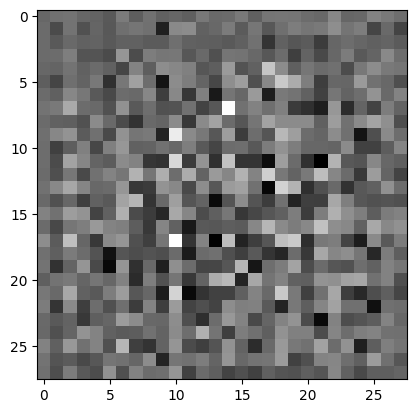

In [7]:
# 임의의 Noise를 G모델에 통과시키면 28*28 사이즈의 랜덤 이미지가 만들어집니다.
test_noise = tf.random.normal([1, 100])
fake_image_test = G(test_noise, training=False)

plt.imshow(fake_image_test[0], cmap='gray')

In [8]:
# 그리고 G모델에서 만들어진 이미지를 D모델에 통과시키면 확률이 나오게 됩니다.
decision = D(fake_image_test, training=False)
print(decision)

tf.Tensor([[0.00225193]], shape=(1, 1), dtype=float32)


### 4. 모델 학습 파라미터 설정

In [9]:
EPOCHS = 50
noise_dim = 100

seed = tf.random.normal([BATCH_SIZE, noise_dim])

# 최적화 방법: Adam
G_optimizer = tf.keras.optimizers.Adam(1e-4)
D_optimizer = tf.keras.optimizers.Adam(1e-4)

In [10]:
# 손실함수: 이진 교차 엔트로피
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def D_loss(real_output, fake_output):
    # 판별자 손실함수
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def G_loss(fake_output):
    # 생성자 손실함수
    return cross_entropy(tf.ones_like(fake_output), fake_output)

### 5. 모델 학습

#### 훈련 데이터셋 학습 함수 정의

In [11]:
# 아래의 train_step 함수에는 @tf.function이라는 데코레이터가 사용됩니다.
# 특정한 상황일때 함수를 'compile' 하여 속도가 빨라진다고 대략적으로 이해하시면 됩니다!
@tf.function
def train_step(real_images):  
  
    noises = tf.random.normal([BATCH_SIZE, noise_dim])
  
    with tf.GradientTape() as gen_tape, tf.GradientTape() as dsc_tape:
        # tf.GradientTape()를 사용하여 생성자(G)와 판별자(D) 모델을 학습시키는데 필요한 연산들을 기록
        # gen_tape과 dsc_tape는 각각 생성자와 판별자 모델의 손실 함수에 대한 기울기(gradient)를 계산하기 위해 사용
        fake_images = G(noises, training=True)

        real_output = D(real_images, training=True)
        fake_output = D(fake_images, training=True)

        gen_loss = G_loss(fake_output)
        dsc_loss = D_loss(real_output, fake_output)
    
    # 손실 함수값을 이용하여 gen_tape.gradient 함수와 dsc_tape.gradient 함수를 사용하여 각 모델의 기울기(gradient)를 계산
    gen_gradients = gen_tape.gradient(gen_loss, G.trainable_variables)
    dsc_gradients = dsc_tape.gradient(dsc_loss, D.trainable_variables)
  
    # G_optimizer.apply_gradients와 D_optimizer.apply_gradients 함수를 사용하여 기울기를 이용하여 각 모델의 가중치를 업데이트
    G_optimizer.apply_gradients(zip(gen_gradients, G.trainable_variables)) 
    D_optimizer.apply_gradients(zip(dsc_gradients, D.trainable_variables))

#### 테스트 데이터셋 학습 함수 정의

In [12]:
def test_step(real_images):  
    noises = tf.random.normal([BATCH_SIZE, noise_dim])
  
    fake_images = G(noises, training=False)
  
    real_output = D(real_images, training=False)
    fake_output = D(fake_images, training=False)    
  
    gen_loss = G_loss(fake_output)
    dsc_loss = D_loss(real_output, fake_output)
  
    print("Generator loss:", gen_loss.numpy(), "Discriminator loss:", dsc_loss.numpy())
    
    return gen_loss.numpy(), dsc_loss.numpy()

#### 손실함수 그래프 함수 정의

In [13]:
def plot_loss(losses) :
    plt.figure(figsize=(10,10))

    plt.plot(losses[0], label="Generator losses")
    plt.plot(losses[1], label="Discriminator losses")
    plt.xlabel("Epochs")
    plt.ylabel("Losses")
    plt.legend()
    plt.show()

In [14]:
# 학습 함수
def train(dataset, epochs):
    gen_losses = []
    dsc_losses = []

    for epoch in range(epochs):
        start = time.time()
    
        for i, image_batch in enumerate(dataset):
            train_step(image_batch)
            if i == 0:
                gen_loss, dsc_loss = test_step(image_batch)
                gen_losses.append(gen_loss)
                dsc_losses.append(dsc_loss)
        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start)) 

    losses = [gen_losses, dsc_losses]
    plot_loss(losses)

Generator loss: 0.69136703 Discriminator loss: 1.3404197
Time for epoch 1 is 18.70880627632141 sec
Generator loss: 0.56167644 Discriminator loss: 1.3140675
Time for epoch 2 is 20.51021385192871 sec
Generator loss: 0.9413049 Discriminator loss: 1.2677897
Time for epoch 3 is 20.33798050880432 sec
Generator loss: 0.7899194 Discriminator loss: 1.2356615
Time for epoch 4 is 20.32815170288086 sec
Generator loss: 0.9451175 Discriminator loss: 1.1113836
Time for epoch 5 is 20.28603982925415 sec
Generator loss: 1.0027944 Discriminator loss: 0.98457265
Time for epoch 6 is 20.23318886756897 sec
Generator loss: 1.1605844 Discriminator loss: 0.8381725
Time for epoch 7 is 11.99886417388916 sec
Generator loss: 0.97933793 Discriminator loss: 1.221588
Time for epoch 8 is 8.799416780471802 sec
Generator loss: 0.9846823 Discriminator loss: 1.120187
Time for epoch 9 is 8.722087144851685 sec
Generator loss: 1.0363607 Discriminator loss: 0.9872869
Time for epoch 10 is 8.728205442428589 sec
Generator loss: 1

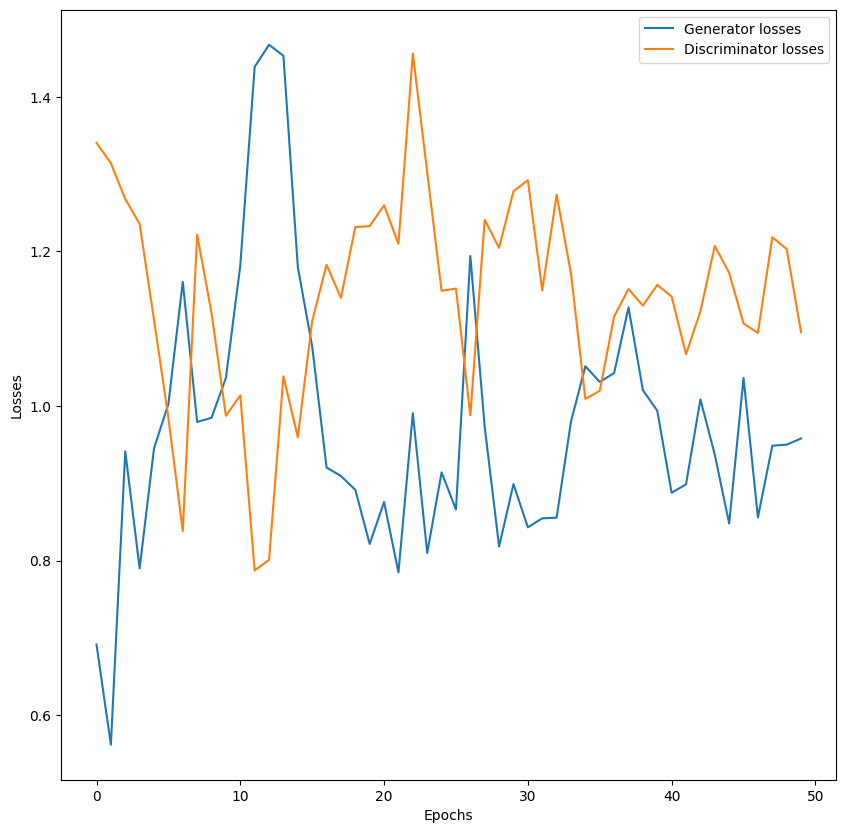

In [15]:
train(train_dataset, EPOCHS)

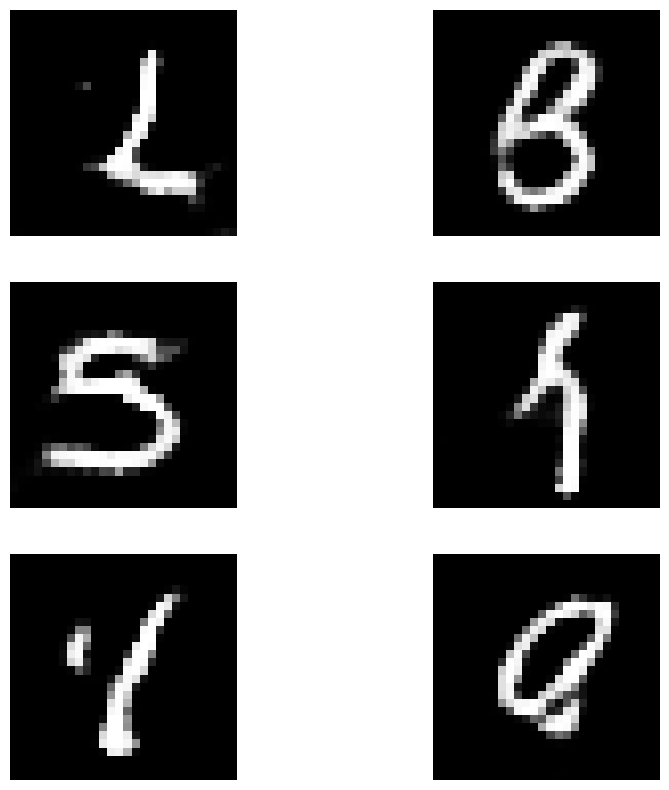

In [16]:
# Generator가 만들어 낸 노이즈 이미지 테스트 해보기

import matplotlib.pyplot as plt

noises = tf.random.normal([50, 100])
generated_image = G(noises, training=False)

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10,10))

for ax in axes.flat:
    ax.axis('off')

axes[0,0].imshow(generated_image[0], cmap='gray')
axes[0,1].imshow(generated_image[1], cmap='gray')
axes[1,0].imshow(generated_image[2], cmap='gray')
axes[1,1].imshow(generated_image[3], cmap='gray')
axes[2,0].imshow(generated_image[4], cmap='gray')
axes[2,1].imshow(generated_image[5], cmap='gray')

plt.show()